# Exercise 2

## Discrete random variables

### 1. Choose a value for the probability parameter p in the geometric distribution and simulate 10,000 outcomes. You can experiment with a small, moderate and large value if you like.

In order to mke a geometric distribution, we look in Section 3.2 Simulation, by Ross. Specificially, we first draw a number from a uniform distribution, then take the following function and use that as the data points:
$$
X=\lceil\frac{\log (1-U)}{\log (1-p)}\rceil
$$
Where $U$ is the drawn number, and $p$ is the $p$ we set. This is equivalent to draw from a geometric distribution.

We simulate $n=10000$ outcomes with the a geometric distribution, with the values $p_1=0.2$, $p_2=0.5$, and $p_3=0.8$ to test different values. For the $\chi^2$ tests, we ensure the number of values for each bin is atleast 5.

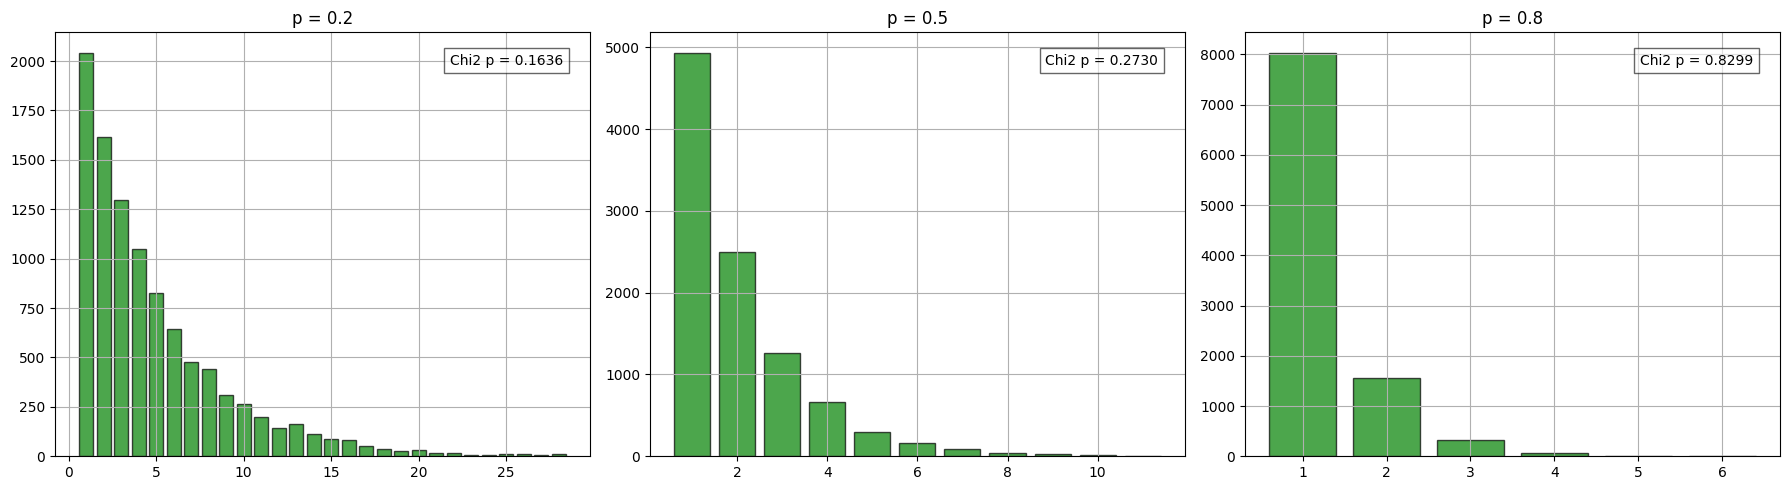

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import chisquare, geom
from statsmodels.sandbox.stats.runs import runstest_1samp
import time
np.random.seed(42)

p_values = [0.2, 0.5, 0.8]
n_samples = 10000
max_bins = 30

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, p in enumerate(p_values):
    uniform_randoms = np.random.uniform(0, 1, size=n_samples)
    data = np.ceil(np.log(1 - uniform_randoms) / np.log(1 - p)).astype(int)
    bins = np.arange(1, min(data.max(), max_bins) + 1)
    counts, _ = np.histogram(data, bins=np.append(bins, bins[-1] + 1))
    probs = geom.pmf(bins, p)
    expected_counts = probs * n_samples
    expected_counts *= counts.sum() / expected_counts.sum()
    cutoff_idx = np.argmax(expected_counts < 5)
    if expected_counts[cutoff_idx] < 5:
        counts = np.append(counts[:cutoff_idx], counts[cutoff_idx:].sum())
        expected_counts = np.append(expected_counts[:cutoff_idx], expected_counts[cutoff_idx:].sum())
        bins = np.append(bins[:cutoff_idx], f'>={bins[cutoff_idx]}')  # optional label adjustment
    chi2_stat, p_val = chisquare(f_obs=counts, f_exp=expected_counts)
    x_labels = range(1, len(counts) + 1)
    axs[i].bar(x_labels, counts, width=0.8, align='center', alpha=0.7, edgecolor='black', color='green')
    axs[i].set_title(f'p = {p}')
    axs[i].grid(True)
    axs[i].text(0.95, 0.95, f'Chi2 p = {p_val:.4f}', ha='right', va='top',
                transform=axs[i].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()


The experiments show that as $p$ increases, the distribution becomes more concentrated near 1. 

Additionally, the $\chi^2$ test compares the observed frequencies to the expected frequencies in a geometric model. For $p=0.2$, it has a low p value, meaning the null hypothesis is discarded - therefore, there is evidence to suggest that the observed data does not fit a geometric distribution well.

As for $p=0.5$ and $p=0.8$, they both have high p-values, meaning we fail to discard the null hypothesis, suggesting those p-values result in a good fit between the simulated values and the fit of a geometric distribution.

### 2. Simulate the 6 point distribution with


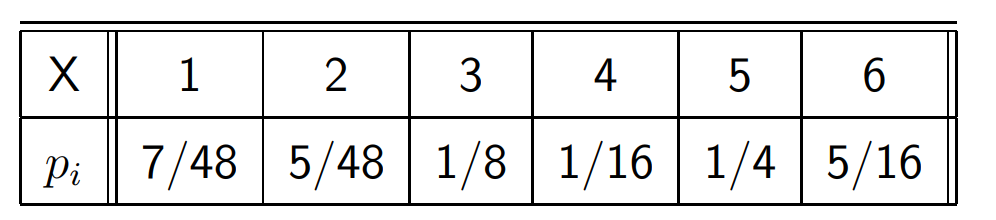



### (a) by applying a direct (crude) method
### (b) by using the the rejction method
### (c) by using the Alias method

For the 6-point distribution, we have the following:

$X=\{1,2,3,4,5,6\}$

$p_i=\{7/48,5/48,1/8,1/16,1/4,5/16\}$

We set $n=10000$

In [34]:
n = 10000
X = np.array([1, 2, 3, 4, 5, 6])
P = np.array([7/48, 5/48, 1/8, 1/16, 1/4, 5/16])
cum_P = np.cumsum(P)

U = np.random.uniform(0, 1, n)
samples = np.zeros(n, dtype=int)

def chi2_test(samples, p, check=True):

    _, n = np.unique(samples, return_counts=True)

    n_exp = p * np.sum(n)

    T = np.sum((n - n_exp)** 2 / n_exp)
    dof = len(p) - 1
    if check:
        print("Degrees of freedom:", dof)

    # test stat follows chi2(k - 1), week 1 slide 10
    return 1 - chi2.cdf(T, len(p) - 1)

$\textbf{(a)}$ The direct (crude) method works by dividing the unit interval $[0,1]$ into segments, where a uniform random number is generated and mapped to the corresponding interval

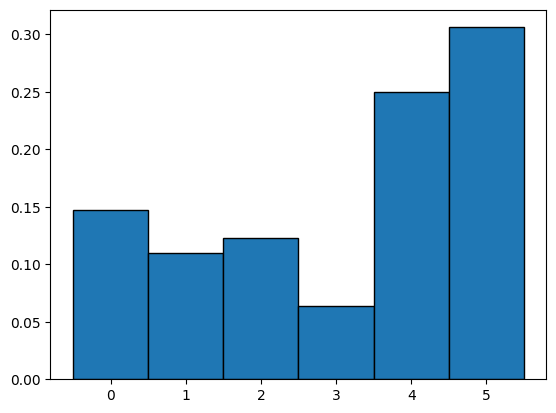

Degrees of freedom: 5
P-val (crude)    : 0.4503273164766495


In [37]:
def discrete_crude(n, p):
    # not exactly the same crude method as in the slides, but definitely crude
    us = uniform.rvs(size=n)

    vals = np.zeros_like(us)
    thresh = p[0]

    for p_i in p[1:]:
        vals += thresh < us
        thresh += p_i

    return vals

crude_vals = discrete_crude(n, P)
plt.hist(crude_vals, bins=np.arange(len(P)+1)-0.5, edgecolor='black', density=True)
plt.show()
print("P-val (crude)    :", chi2_test(crude_vals, P))

The histogram closely matches the target probabilities, with higher bars for outcomes with larger assigned probabilities, confirming that the method correctly maps uniform random values to the specified discrete distribution. The degrees of freedom is calculated as $6-1=5$. Furthermore, the p-value is high, meaning the generated distribution in the method would follow a $\chi^2$ distribution.

$\textbf{(b)}$ The rejection method works by generating candidate outcomes from a uniform distribution and accepting them with a probability proportional to the target probability. $c$ is calculated as the maximum value of $p_i$ multiplied by 6.

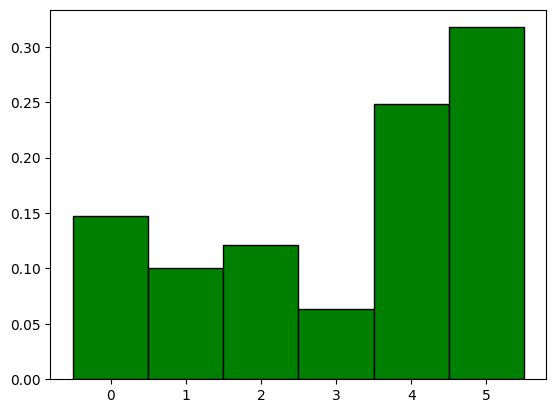

Degrees of freedom: 5
P-val (rejection): 0.6251799233936399


In [39]:
def discrete_rejection(n, p):
    c = np.max(p)
    k = len(p)

    vals = np.empty(n)
    for j in range(n):
        while True:
            i = int(np.floor(k * uniform.rvs())) # int may just round down on its own, but better safe than sorry
            if uniform.rvs() <= p[i] / c:
                vals[j] = i
                break

    return vals

rejection_vals = discrete_rejection(n, P)
plt.hist(rejection_vals, bins=np.arange(len(P)+1)-0.5, edgecolor='black', density=True, color='green')
plt.show()
print("P-val (rejection):", chi2_test(rejection_vals, P))

The bars are almost identifical to the ones in the histogram from the previous assignment, suggesting this method also correctly maps uniform random values to the specified discrete distribution. Once again, the p-value is high, suggesting the data is consistent with the distribution of $P$.

$\textbf{(c)}$ Now, the Alias method is used to sample from a discrete distribution with unequal probabilities. It involves a preprocessing step where two tables are constructed: a probability table \( F \), and an alias table \( L \):

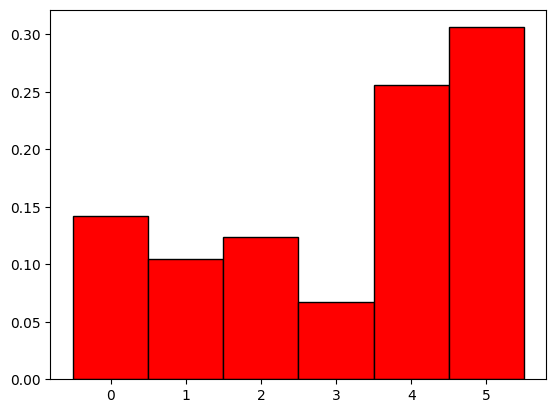

Degrees of freedom: 5
P-val (alias)    : 0.24777427066016733


In [42]:
def generate_f_and_l(p):
    k = len(p)
    L = np.arange(k)
    F = p * k
    G = np.where(F >= 1)[0]
    S = np.where(F <= 1)[0]

    while S.size:
        i = G[0]
        j = S[0]
        L[j] = i
        F[i] = F[i] - (1 - F[j])
        if F[i] < 1 - 1e-8:
            G = G[1:]
            S = np.append(S, np.array([i]))
        S = S[1:]

    return F, L

def discrete_alias(n, f, l):
    k = len(f)
    
    vals = np.empty(n)
    for j in range(n):
        i = int(np.floor(k * uniform.rvs()))
        if uniform.rvs() <= f[i]:
            vals[j] = i
        else:
            vals[j] = l[i]

    return vals

fs, ls = generate_f_and_l(P)
alias_vals = discrete_alias(n, fs, ls)

plt.hist(alias_vals, bins=np.arange(len(P)+1)-0.5, edgecolor='black', density=True, color='red')
plt.show()
print("P-val (alias)    :", chi2_test(alias_vals, P))

In this instance, a high p-value for the Alias method is obtained, meaning the method correctly maps uniform random values to the specified discrete distribution (in this instance). However, as the p value alternates between runs, it would be valuable to see if the p-value changes across e.g., 5 runs with each method:

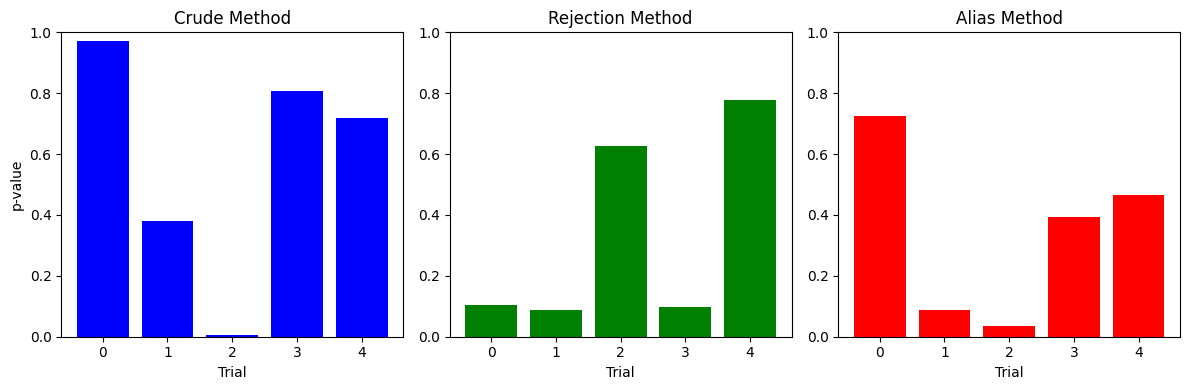

In [44]:
num_trials = 5
pvals_crude, pvals_rejection, pvals_alias = [], [], []

fs, ls = generate_f_and_l(P)

for _ in range(num_trials):
    pvals_crude.append(chi2_test(discrete_crude(n, P), P, check=False))
    pvals_rejection.append(chi2_test(discrete_rejection(n, P), P, check=False))
    pvals_alias.append(chi2_test(discrete_alias(n, fs, ls), P, check=False))

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.bar(range(num_trials), pvals_crude, color='blue')
plt.title("Crude Method")
plt.ylim(0, 1)
plt.xlabel("Trial")
plt.ylabel("p-value")

plt.subplot(1, 3, 2)
plt.bar(range(num_trials), pvals_rejection, color='green')
plt.title("Rejection Method")
plt.ylim(0, 1)
plt.xlabel("Trial")

plt.subplot(1, 3, 3)
plt.bar(range(num_trials), pvals_alias, color='red')
plt.title("Alias Method")
plt.ylim(0, 1)
plt.xlabel("Trial")

plt.tight_layout()
plt.show()


These results show that the p-values vary between runs for each of the three sampling methods. This inherent variability is expected due to the randomness in sampling and the finite sample size (n = 10,000). However, as the number of samples $n\rightarrow\infty$, the empirical distribution produced by each method should converge to the true target distributions. And naturally, the p-values from the $\chi^2$-tests should tend toward a uniform distribution on [0, 1). 

### 3. Compare the three different methods using adequate criteria, then discuss the results.

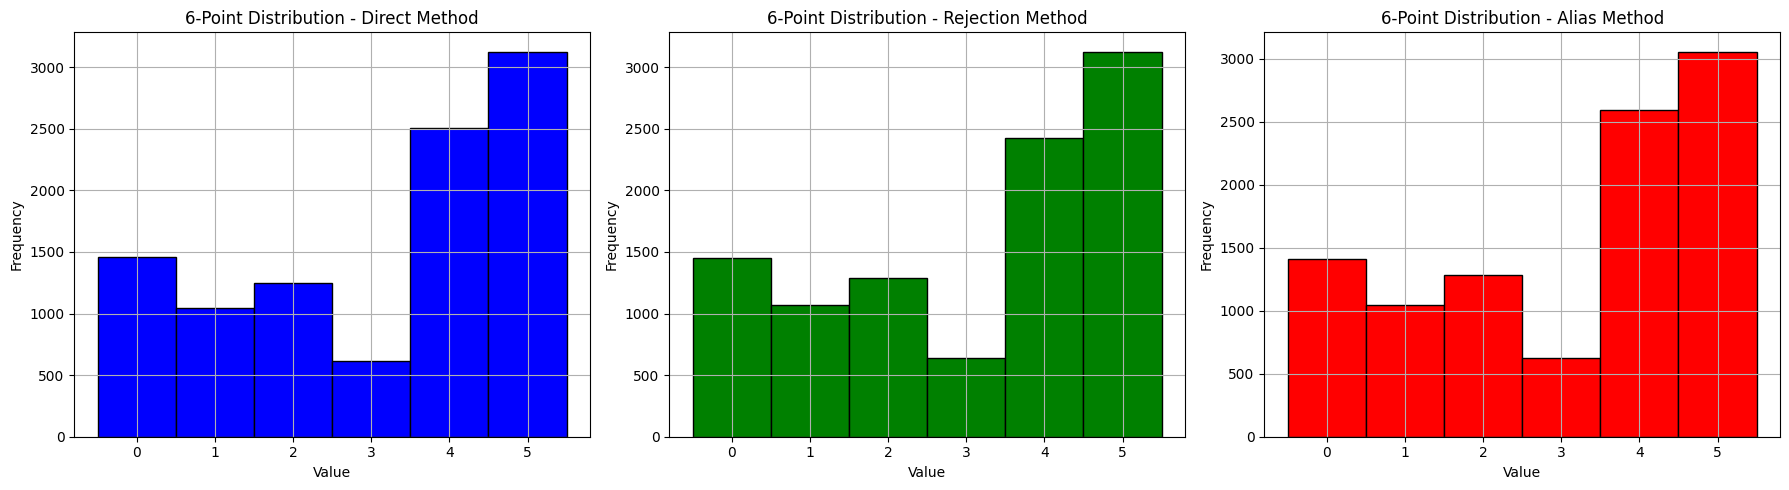

Method               KL Divergence   MAE        Runtime (ms)   
Direct Method        0.000017        4.78       4.37           
Rejection Method     0.000225        26.78      2701.49        
Alias Method         0.000372        40.78      1206.61        


In [52]:
results = {}
for name, method in [
    ('Direct Method', lambda: discrete_crude(n, P)),
    ('Rejection Method', lambda: discrete_rejection(n, P)),
    ('Alias Method', lambda: discrete_alias(n, *generate_f_and_l(P)))
]:
    start = time.time()
    samples = method()
    end = time.time()
    
    obs_counts = np.array([np.sum(samples == xi) for xi in bins])
    expected_counts = P * n
    obs_dist = obs_counts / n
    kl = entropy(obs_dist + 1e-10, P)
    mae = np.mean(np.abs(obs_counts - expected_counts))
    runtime_ms = (end - start) * 1000

    results[name] = {
        'samples': samples,
        'kl': kl,
        'mae': mae,
        'runtime_ms': runtime_ms
    }

# --- Plotting ---
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'green', 'red']

for i, (method_name, res) in enumerate(results.items()):
    axs[i].hist(res['samples'], bins=np.arange(len(P)+1)-0.5, edgecolor='black', color=colors[i])
    axs[i].set_title(f"6-Point Distribution - {method_name}")
    axs[i].set_xlabel("Value")
    axs[i].set_ylabel("Frequency")
    axs[i].set_xticks(X)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

# --- Print Metrics Table ---
print(f"{'Method':<20} {'KL Divergence':<15} {'MAE':<10} {'Runtime (ms)':<15}")
for name, res in results.items():
    print(f"{name:<20} {res['kl']:<15.6f} {res['mae']:<10.2f} {res['runtime_ms']:<15.2f}")

All three methods approximate the target 6-point distribution, but with varying levels of accuracy. They all share almost the same histograms.

The Direct method achieves the lowest KL divergence (Kullback-Leibler divergence, meaning how much information is lost when we approximate the true distribution using the method), and also the lowest MAE (mean average error). Furthermore, it is also the fatest method.

The Rejection method has a higher KL divergence and MAE than the Direct method, while also taking massively longer to run.

The Alias method performs the worst of the bunch in terms of KL divergence and MAE, but does have a better runtime. 

However, as this is a somewhat small-scale sampling with only $n=10000$

### 4. Give recommendations of how to choose the best suite method in different settings, i.e., discuss the advantages and drawbacks of each method. If time permits substantiate by running experiments.

In this small case, the Direct method proved to be the best in terms of KL divergence, MAE, and runtime. However, if we were to upscale the number of samples $n$, say to millions, the Alias method would be more advantageous, since its sampling step runs in constant time $O(1)$. after an initial preprocessing phase. In contrast, the Direct and Rejection methods require $O(nk)$, which becomes increasingly costly as the number of classes $k$ grows. But since this is a relatively small-scale setup, the Direct and Rejection methods outperform the Alias method.

# Exercise 3

## 1. Generate simulated values from the following distributions
### (a) Exponential distribution
### (b) Normal distribution (at least with standard Box-Mueller)
### (c) Pareto distribution, with β = 1 and experiment with different values of k values: k = 2.05, k = 2.5, k = 3 and k = 4.
## Verify the results by comparing histograms with analytical results and perform tests for distribution type.

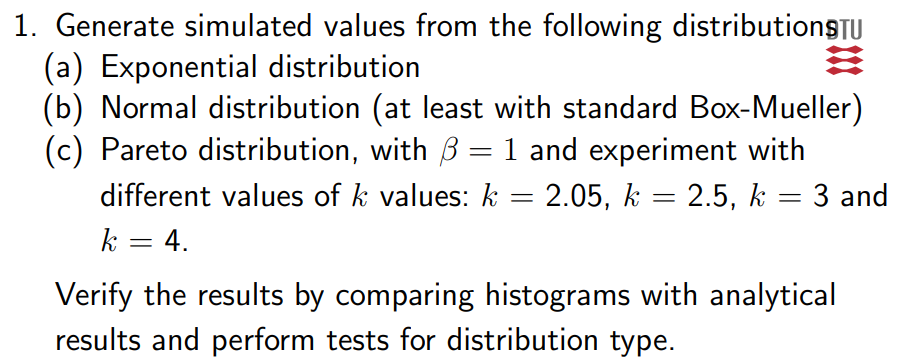

$\textbf{(a)}$ To genereate values from an exponential distribution, we use the inverse transform method. We know that the exponential distribution has the following CDF:
$$
F(x) = 1-e^{-\lambda x}
$$
If we solve for $x=F^{-1}(u)$, we get:
$$
x=-\frac{1}{\lambda}\log (U), \quad U\sim \text{Uniform}(0,1)
$$


For simplicity's sake, we set $\lambda = 1$ and do $n=10000$ runs. We plot the distribution of generated values together with the theoreitcal PDF, and also do a KS test:

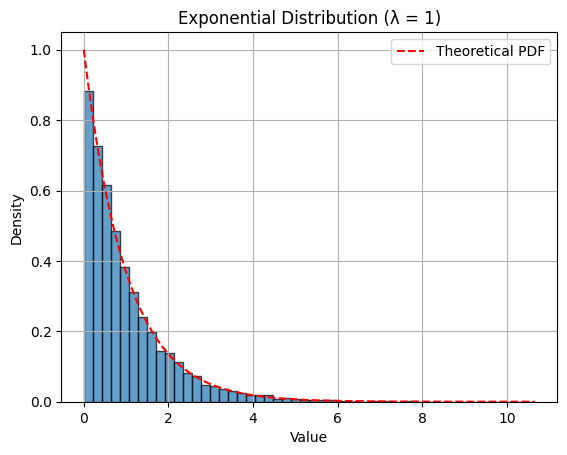

KS test p-value: 0.6099


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, kstest, norm
n = 10000
lam = 1

U = np.random.uniform(0, 1, n)
samples = -np.log(U) / lam  

plt.hist(samples, bins=50, edgecolor='black', alpha=0.7, density=True)
x = np.linspace(0, np.max(samples), 200)
plt.plot(x, expon.pdf(x, scale=1/lam), 'r--', label='Theoretical PDF')
plt.title("Exponential Distribution (λ = 1)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

D, p = kstest(samples, 'expon', args=(0, 1/lam))
print(f"KS test p-value: {p:.4f}")

KS test p-value: 0.6099

As can be observed, the simulated values from the exponential distribution with $\lambda = 1$ match the theoretical PDF, and the high KS test p-value confirms an excellent fit of the distribution. 

$\textbf{(b)}$ Here, we do the same but for a normal distribution with a standard Box-Mueller transformation. Specifically, the Box-Mueller transform is a method to generate samples from a standard normal distribution using two independent uniform random variables, $U_1 , U_2 \sim \text{Uniform}(0,1)$. After these have been generated, then $Z_1$ and $Z_2$ are computed:
$$
Z_1 = \sqrt{-2 \log U_1} \cos (2\pi U_2)
$$
$$
Z_2 = \sqrt{-2 \log U_1} \sin (2\pi U_2)
$$
In turn, $Z_1, Z_2 \sim \text{N}(0,1)$

We generate 10000 values using this method:

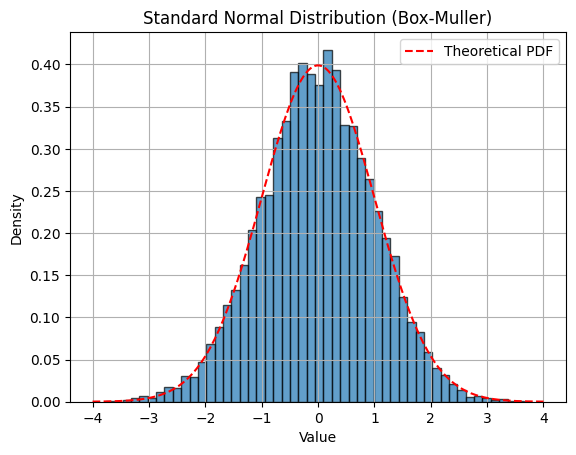

KS test p-value: 0.7394


In [6]:
U1 = np.random.uniform(0, 1, n//2)
U2 = np.random.uniform(0, 1, n//2)

Z1 = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)
Z2 = np.sqrt(-2 * np.log(U1)) * np.sin(2 * np.pi * U2)
samples = np.concatenate([Z1, Z2])

plt.hist(samples, bins=50, density=True, edgecolor='black', alpha=0.7)
x = np.linspace(-4, 4, 200)
plt.plot(x, norm.pdf(x), 'r--', label='Theoretical PDF')
plt.title("Standard Normal Distribution (Box-Muller)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.show()

D, p = kstest(samples, 'norm')
print(f"KS test p-value: {p:.4f}")

KS test p-value: 0.7394

This shows that the Box-Mueller method is capable of accurately generating samples from the standard normal distribution, as the theoretical pdf matches closely to the 10000 generated values. Furthermore, the KS test value indicates no significant devation from normality.

$\textbf{(c)}$ Now, we generate 10000 values using the Pareto distribution 

In the textbook, the CDF of the Pareto distribution is
$$
F(x) = 1-(\frac{\beta}{x})^k , \quad \text{for}\ x\geq\beta 
$$

When executing the inverse transformation of this, the following is reached:

Solving this for $x$ results in:
$$
x = \frac{\beta}{(1-U)^{1/k}}
$$
Here, $U\sim\text{Uniform}(0,1)$.

Using this, 10000 values can be created for each different value of $k$:

KS test p-value for k = 2.05: 0.3821
KS test p-value for k = 2.5: 0.9570
KS test p-value for k = 3: 0.1476
KS test p-value for k = 4: 0.8333


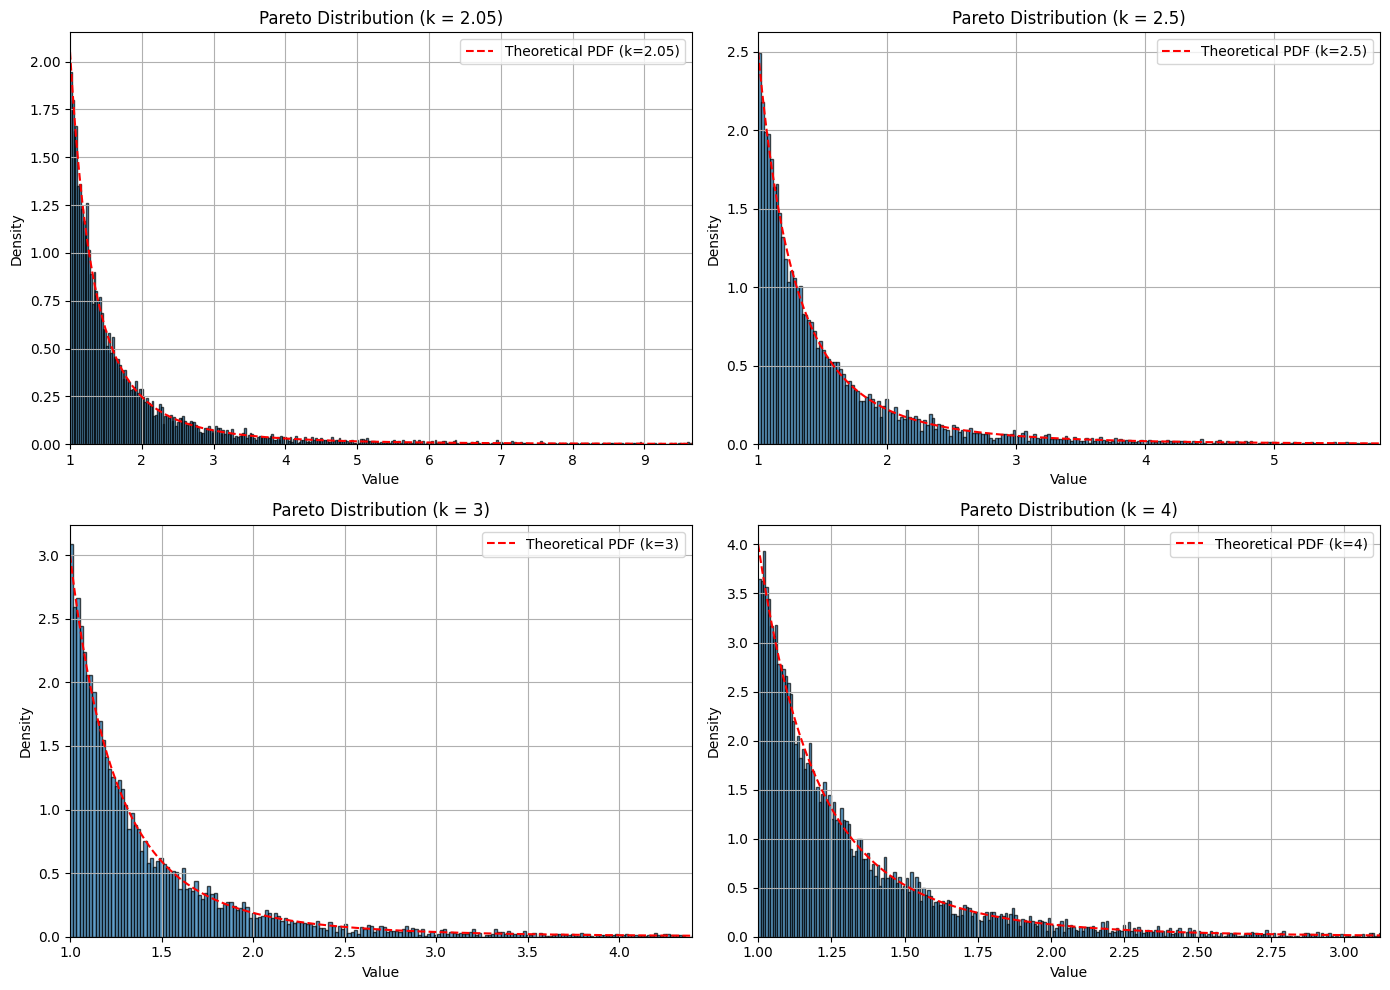

In [59]:
k_values = [2.05, 2.5, 3, 4]
beta = 1

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, k in enumerate(k_values):
    U = np.random.uniform(0, 1, n)
    samples = beta / ((1 - U) ** (1 / k))
    x_max = np.percentile(samples, 99)  
    x = np.linspace(beta, x_max, 300)

    axs[i].hist(samples, bins=1500, density=True, alpha=0.7, edgecolor='black')
    axs[i].plot(x, pareto.pdf(x, b=k, scale=beta), 'r--', label=f'Theoretical PDF (k={k})')
    axs[i].set_title(f'Pareto Distribution (k = {k})')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Density')
    axs[i].set_xlim([beta, x_max])     
    axs[i].grid(True)
    axs[i].legend()

    D, p = kstest(samples, 'pareto', args=(k, 0, beta))
    print(f"KS test p-value for k = {k}: {p:.4f}")

plt.tight_layout()
plt.show()

KS test p-value for k = 2.05: 0.3821

KS test p-value for k = 2.5: 0.9570

KS test p-value for k = 3: 0.1476

KS test p-value for k = 4: 0.8333

The histograms show that the simulated Pareto distributions closely follow the theoretical PDFs for all tested $k$. As $k$ increases, the tail becomes thinner and the distribution becomes more concentrated near 1. The KS test p-values are all above 0.05, confirming that the samples are consistent with the target Pareto distributions.

### 2. For the Pareto distribution with support on [β,∞[ compare mean value and variance, with analytical results, which can be calculated as E(X) = β* k/(k-1)  (for k > 1) and Var(X) = β^2 * (k/((k-1)^2 (k-2)). Explain problems if any

Now, we compared the analytical results with the mean and variance of the Pareto distirubtion, E(X) and Var(X), with the 4 different values of $k$ and $\beta=1$:

In [60]:
print(f"{'k':<6} {'Empirical Mean':<18} {'Theoretical Mean':<20} {'Empirical Var':<18} {'Theoretical Var'}")

for k in k_values:
    U = np.random.uniform(0, 1, n)
    samples = (1 / (1 - U))**(1 / k)

    empirical_mean = np.mean(samples)
    empirical_var = np.var(samples)

    if k > 1:
        theoretical_mean = beta * k / (k - 1)
    else:
        theoretical_mean = np.nan

    if k > 2:
        theoretical_var = (beta**2) * k / ((k - 1)**2 * (k - 2))
    else:
        theoretical_var = np.nan

    print(f"{k:<6} {empirical_mean:<18.4f} {theoretical_mean:<20.4f} {empirical_var:<18.4f} {theoretical_var}")

k      Empirical Mean     Theoretical Mean     Empirical Var      Theoretical Var
2.05   1.9080             1.9524               4.3038             37.18820861678019
2.5    1.6602             1.6667               2.0525             2.2222222222222223
3      1.5040             1.5000               0.7962             0.75
4      1.3254             1.3333               0.1946             0.2222222222222222


$\begin{array}{|c|c|c|c|c|}
\hline
k & \text{Empirical Mean} & \text{Theoretical Mean} & \text{Empirical Var} & \text{Theoretical Var} \\
\hline
2.05 & 1.9080 & 1.9524 & 4.3038 & 37.1882 \\
2.5  & 1.6602 & 1.6667 & 2.0525 & 2.2222 \\
3    & 1.5040 & 1.5000 & 0.7962 & 0.7500 \\
4    & 1.3254 & 1.3333 & 0.1946 & 0.2222 \\
\hline
\end{array}$

For all values of $k$, the empirical means closely match the theoretical means, which aligns with the known properties of the Pareto distribution. However, for $k=2.05$, while the mean is defined, the variance is finite but extremely large, and becomes infinite as $k\rightarrow2$. This explains the large observed empirical variance and illustrates the sensitivity of the distribution's second moment in the heavy-tailed regime. For higher values of $k \geq 2.5$, both mean and variance converge more reliably to their theoretical values, and the distribution stabilizes. Thus, increasing $k$ does reduce the variance and thus, improve the allignment of the theoretical and empirical moments. 

### 3. For the normal distribution generate 100 95% confidence intervals for the mean and variance, each based on 10 observations. Discuss the results

This code simulates 100 independent samples of size 10 from a standard normal distribution, and constructs 95% confidence intervals for both the mean and variance. Afterwards, it estimates the empirical coverage probability by counting how often the true values fall within these intervals.

In [62]:
n = 10
N = 100  
true_mean = 0
true_var = 1

mean_contains = 0
var_contains = 0

alpha = 0.05
t_crit = t.ppf(1 - alpha / 2, df=n - 1)

for _ in range(N):
    data = np.random.normal(0, 1, n)
    xbar = np.mean(data)
    s = np.std(data, ddof=1)
    s2 = np.var(data, ddof=1)

    ci_mean = (xbar - t_crit * s / np.sqrt(n), xbar + t_crit * s / np.sqrt(n))
    if ci_mean[0] <= true_mean <= ci_mean[1]:
        mean_contains += 1

    chi2_lower = chi2.ppf(alpha / 2, df=n - 1)
    chi2_upper = chi2.ppf(1 - alpha / 2, df=n - 1)
    ci_var = ((n - 1) * s2 / chi2_upper, (n - 1) * s2 / chi2_lower)
    if ci_var[0] <= true_var <= ci_var[1]:
        var_contains += 1

print(f"Mean CI coverage: {mean_contains} / {N}")
print(f"Variance CI coverage: {var_contains} / {N}")

Mean CI coverage: 95 / 100
Variance CI coverage: 92 / 100


Out of 100 simulations, 95 out of 100 confidence intervals for the means contained the true population mean, which is 0.

And out of the 100 simulation, 92 out of 100 confidence intervals for the variance contained the true population mean, which is 1.

This shows that not every time the 95% confidence intervals capture the true parameter, but they do do it succesfully 95% of the time. If we were to increase $N$, we would approximate 95 better.

### 4. Simulate from the Pareto distribution using composition.

In order to simulate from the Pareto distribution, we utilize the inverse transform method. This technique involves generating samples from a distribution, $X\sim$ Uniform(0,1), and then applying the inverse of the Pareto CDF:
$$
F^{-1}(u) = \beta\cdot (1-u)^{1/k},\quad \text{for }u\in(0,1)
$$

If we solve this for $x$ in terms of $u=F(x)$, we get:
$$
u=1-(\frac{\beta}{x})^k\quad\rightarrow\quad x=\frac{\beta}{U^{1/k}}
$$

This, we can plot:


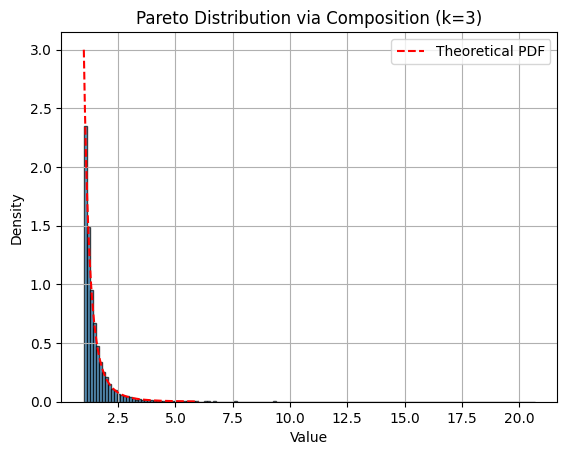

KS test p-value: 0.8516


In [70]:
n = 10000
k = 3
beta = 1

U = np.random.uniform(0, 1, n)
X = beta / U**(1 / k)  

x = np.linspace(1, np.percentile(X, 99.5), 200)
plt.hist(X, bins=150, density=True, edgecolor='black', alpha=0.7)
plt.plot(x, pareto.pdf(x, b=k, scale=beta), 'r--', label='Theoretical PDF')
plt.title(f'Pareto Distribution via Composition (k={k})')
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()

D, p = kstest(X, 'pareto', args=(k, 0, beta))
print(f"KS test p-value: {p:.4f}")

Here, we see the generated samples follow the theoretical PDF. Furthermore, the high KS indicates that the generated values are in fact consistent with a Pareto distribution.